# Хід роботи
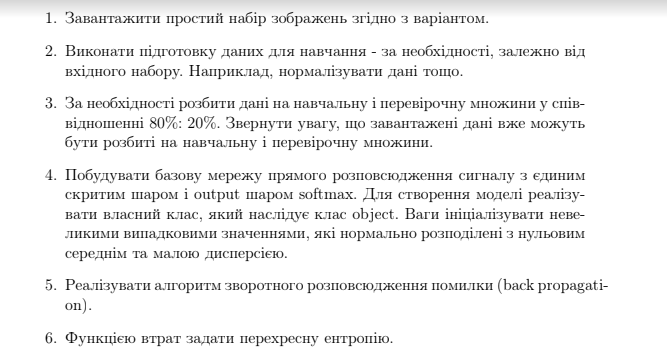
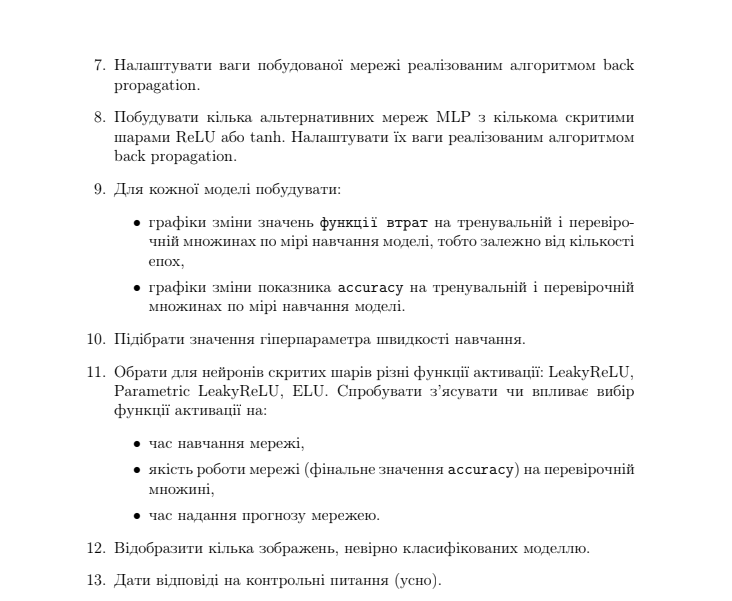

## 0 - Data Loading

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time 

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
CSV_PATH = '/home/ivanbashtovyi/Documents/iad/lab2/archive/chinese_mnist.csv'
IMG_PATH = '/home/ivanbashtovyi/Documents/iad/lab2/archive/data'

In [3]:
csv = pd.read_csv(CSV_PATH)
filename = csv[['suite_id', 'sample_id', 'code']].values

images = [ cv2.imread(f"{IMG_PATH}/input_{suite_id}_{sample_id}_{code}.jpg") for suite_id, sample_id, code in filename ]
labels = [ [x - 1] for x in csv['code'].values ] 
images = np.array(images)
labels = np.array(labels)


print("images shape:", images.shape)
print("labels shape:", labels.shape)

images shape: (15000, 64, 64, 3)
labels shape: (15000, 1)


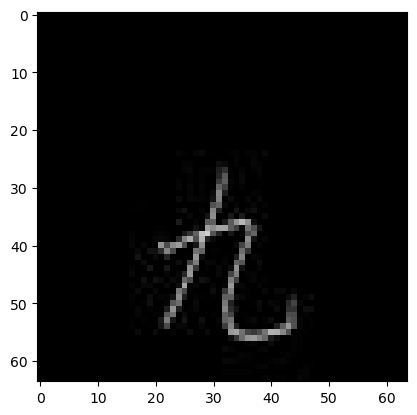

In [4]:
plt.imshow(images[0])

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

images = list(map(rgb2gray, images))

In [6]:
images = np.array(images)
images.shape

(15000, 64, 64)

In [7]:
images = images.reshape(len(images), 4096)
images.shape

(15000, 4096)

In [8]:
labels.shape

(15000, 1)

In [9]:
labels

array([[9],
       [9],
       [9],
       ...,
       [8],
       [8],
       [8]])

In [10]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [11]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


train_images = train_images.reshape(train_images.shape[0], -1).T
test_images = test_images.reshape(test_images.shape[0], -1).T
train_labels = train_labels.reshape(train_labels.shape[0], -1).T
test_labels = test_labels.reshape(test_labels.shape[0], -1).T


print('train set shapes: ', train_images.shape, train_labels.shape)
print('test set shapes: ', test_images.shape, test_labels.shape)

train set shapes:  (4096, 12000) (1, 12000)
test set shapes:  (4096, 3000) (1, 3000)


In [12]:
def plot_digit(x_set, y_set, idx):
    img = x_set.T[idx].reshape(64,64)
    plt.imshow(img, cmap='gray',  interpolation='nearest')
    plt.title('true label: %d' % y_set.T[idx])
    plt.show()

/tmp/ipykernel_30116/1864498088.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('true label: %d' % y_set.T[idx])


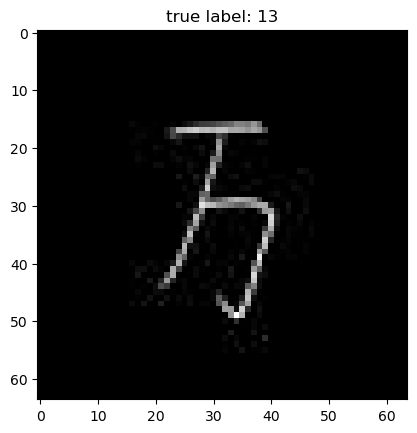

In [13]:
plot_digit(train_images, train_labels, 0) 

## 1 - Helper Functions


In [14]:
class Sigmoid:
  def __call__(self, z):
      return 1 / (1 + np.exp(-z))

  def prime(self, z):
      return self.__call__(z) * (1 - self.__call__(z))

class Tanh:
  def __call__(self, z):
      return np.tanh(z)

  def prime(self, z):
      return 1 - np.tanh(z)**2
      
class ReLU:
  def __call__(self, z):
      return np.maximum(0, z)

  def prime(self, z):
      return np.where(z > 0, 1, 0)

class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def __call__(self, z):
        return np.where(z > 0, z, self.alpha * z)

    def prime(self, z):
        return np.where(z > 0, 1, self.alpha)


# Output activation
class Softmax:
  def __call__(self, z):
      exp_z = np.exp(z - np.max(z, axis=-1, keepdims=True))
      return exp_z / np.sum(exp_z, axis=-1, keepdims=True)


In [15]:
# Activation functions plots

def plot_activation_function(activation_func, activation_prime_func, name):
    x = np.linspace(-10., 10., num=100)
    activation = activation_func(x)
    activation_prime = activation_prime_func(x)

    print(f'{name}:')
    print(f'{activation[:5]}')
    print(f'{name}_prime:')
    print(f'{activation_prime[:5]}')

    plt.plot(x, activation, label=name)
    plt.plot(x, activation_prime, label=f'{name} prime')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(prop={'size': 16})
    plt.show()

def plot_softmax_function(softmax_func):
    x = np.linspace(-10., 10., num=100)
    softmax = softmax_func(x)

    print('Softmax:')
    print(softmax[:5])

    plt.plot(x, softmax, label="Softmax")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(prop={'size': 16})
    plt.show()


Sigmoid:
[4.53978687e-05 5.55606489e-05 6.79983174e-05 8.32200197e-05
 1.01848815e-04]
Sigmoid_prime:
[4.53958077e-05 5.55575620e-05 6.79936937e-05 8.32130942e-05
 1.01838442e-04]


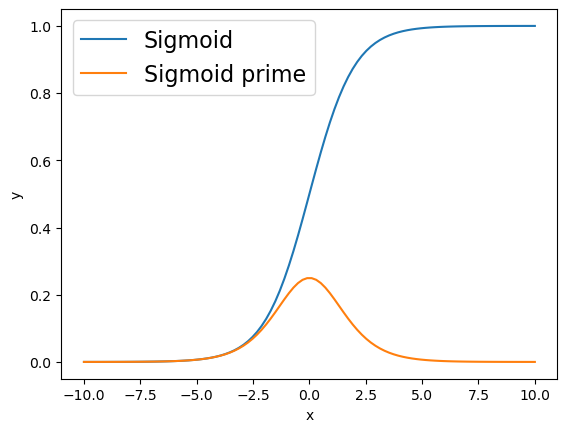

Tanh:
[-1.         -0.99999999 -0.99999999 -0.99999999 -0.99999998]
Tanh_prime:
[8.24461455e-09 1.23493151e-08 1.84976000e-08 2.77068977e-08
 4.15011772e-08]


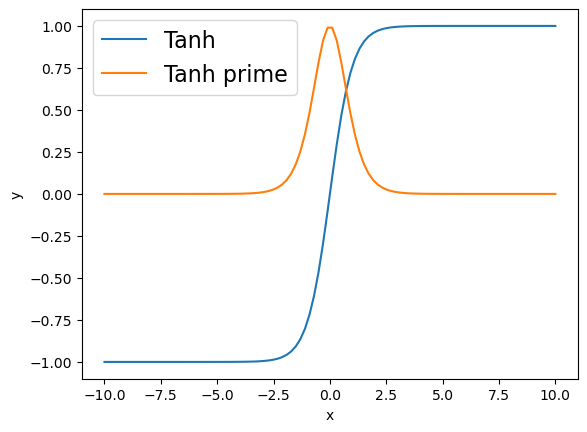

ReLU:
[0. 0. 0. 0. 0.]
ReLU_prime:
[0 0 0 0 0]


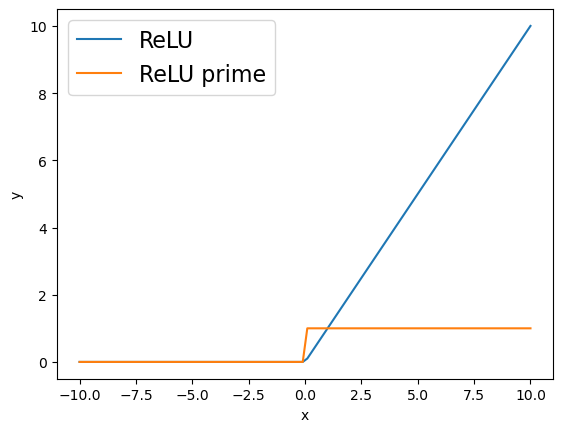

LeakyReLU:
[-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192]
LeakyReLU_prime:
[0.1 0.1 0.1 0.1 0.1]


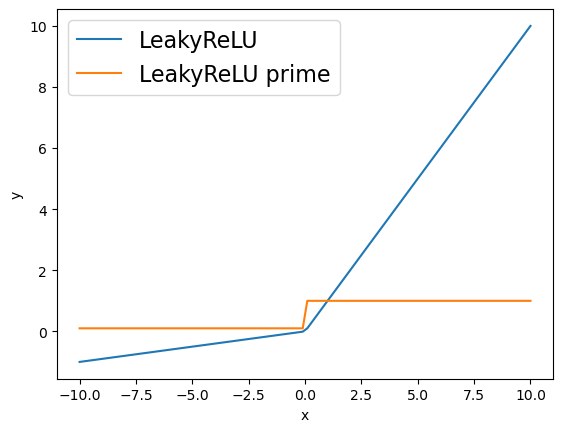

In [16]:
sigmoid = Sigmoid()
relu = ReLU()
tanh = Tanh()
lreulu = LeakyReLU(0.1)

plot_activation_function(sigmoid, sigmoid.prime, 'Sigmoid')
plot_activation_function(tanh, tanh.prime, 'Tanh')
plot_activation_function(relu, relu.prime, 'ReLU')
plot_activation_function(lreulu, lreulu.prime, 'LeakyReLU')



Softmax:
[3.77029476e-10 4.61436094e-10 5.64739054e-10 6.91168729e-10
 8.45902561e-10]


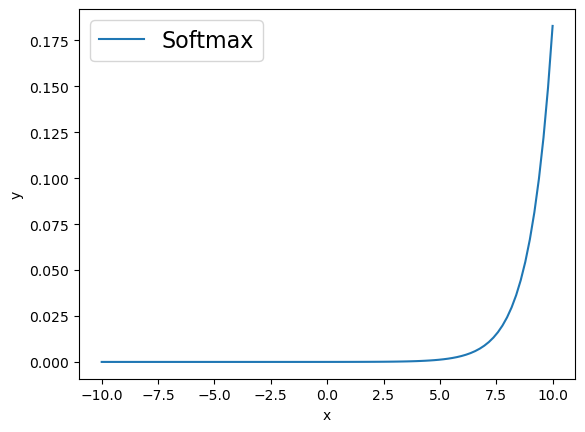

In [17]:
softmax = Softmax()
plot_softmax_function(softmax)

### One-Hot ###


In [18]:
def one_hot(Y, n_classes):
    
    arr = np.zeros((n_classes, Y.shape[1]))
    for i in range(len(Y[0])):
      arr[Y[0][i]][i] = 1.
    return arr


In [19]:
print('encoded:')
print(one_hot(np.asarray([1, 2, 3, 4, 3]).reshape(1, 5), 5))


encoded:
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


### Cost Function ###

Here is cost function for our model:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)}\tag{4}$$
where

$m$ - number of examples;

$n$ - number of classes;

$y$ - input labels;

$a$ - output of hidden layer.


We will use cross entropy loss:
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})\tag{5}$

In [20]:
def compute_cost(A, Y):
    m = Y.shape[1] 
    epsilon = 1e-15  # small constant to avoid log(0)
    
    assert A.shape == Y.shape
    
    # Clip values to avoid log(0)
    A = np.clip(A, epsilon, 1 - epsilon)
    cost = -1/m * np.sum(Y * np.log(A))
    
    return cost


In [21]:
# def compute_cost(A, Y):
    
#     m = Y.shape[1] 
#     cost =  (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
#     return cost


In [22]:
# def compute_cost(AL, Y):
#     m = Y.shape[1]
#     constanta = 0.0001
    
#     if Y.shape[0] == 1:
#         cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
#     else:
#         cost = -(1./m) * np.sum(Y * np.log(AL + constanta))
        
#     cost = np.squeeze(cost)     
    
#     return cost

### Regularization

In order to create less complex (parsimonious) model when you have a large number of features in your dataset, some of the Regularization techniques used to address over-fitting and feature selection are:

1. L1 Regularization

2. L2 Regularization

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the cost function.

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.
The cost is then computed by summing squared diff over all training examples.
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)}+$$<br>$$+\frac{\lambda_1}{m}( ||w_1||_1 + ||w_2||_1) + \frac{\lambda_2}{2m} (||w_1||_2^2+||w_2||_2^2) \tag{6}$$



In [23]:
class Regularization:
    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2

    def l1(self, W, m):
        return (self.lambda_1 / m) * np.linalg.norm(W, ord=1)

    def l1_grad(self, W, m):
        return np.sign(W) * (self.lambda_1 / m)

    def l2(self, W, m):
        return (self.lambda_2 / (2 * m)) * np.linalg.norm(W**2, ord=1)

    def l2_grad(self, W, m):
        return (self.lambda_2 / m) * W


## 2 - Neural Network. General Architecture 


In [24]:
class NeuralNetwork:
    
    def __init__(self, layer_sizes, learning_rate, regularization_params,activation_function=ReLU(), output_function=Softmax()):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation = activation_function
        self.outer_activation = output_function
        self.parameters = {}
        self.cache = {}
        self.regularization = Regularization(regularization_params['lambda_1'], regularization_params['lambda_2'])
        self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(42)

        for i in range(1, len(self.layer_sizes)):
            mean = 0
            std = 0.01  
            
            self.parameters[f'W{i}'] = np.random.normal(mean, std, size=(self.layer_sizes[i], self.layer_sizes[i-1]))
            self.parameters[f'b{i}'] = np.zeros((self.layer_sizes[i], 1))

    def forward_propagation(self, X):
        self.cache['A0'] = X

        for i in range(1, len(self.layer_sizes)):
            self.cache[f'Z{i}'] = self.parameters[f'W{i}'].dot(self.cache[f'A{i-1}']) + self.parameters[f'b{i}']
            self.cache[f'A{i}'] = self.activation(self.cache[f'Z{i}'])

        return self.cache

    def backward_propagation(self, Y):
        m = Y.shape[1]

        self.cache['dZ' + str(len(self.layer_sizes) - 1)] = self.cache['A' + str(len(self.layer_sizes) - 1)] - Y

        for i in reversed(range(2, len(self.layer_sizes))):
            self.cache[f'dZ{i-1}'] = self.parameters[f'W{i}'].T.dot(self.cache[f'dZ{i}']) * self.activation.prime(self.cache[f'Z{i-1}'])

        for i in reversed(range(1, len(self.layer_sizes))):
            self.parameters[f'dW{i}'] = (1 / m) * self.cache[f'dZ{i}'].dot(self.cache[f'A{i-1}'].T)
            self.parameters[f'db{i}'] = (1 / m) * np.sum(self.cache[f'dZ{i}'], axis=1, keepdims=True)

            reg_grads = self.regularization.l1_grad(self.parameters[f'W{i}'], m) + self.regularization.l2_grad(self.parameters[f'W{i}'], m)
            self.parameters[f'dW{i}'] += reg_grads
        

    def update_parameters(self):
        for i in range(1, len(self.layer_sizes)):
            self.parameters[f'W{i}'] -= self.learning_rate * self.parameters[f'dW{i}']
            self.parameters[f'b{i}'] -= self.learning_rate * self.parameters[f'db{i}']

### 3.2 - Model ####



In [25]:
def lr_scheduler(cost, learning_rate, epsilon, reduce_part, k_iters_before):
    
    lr = learning_rate

    if cost[-k_iters_before] - cost[-1] < epsilon:
        lr /= reduce_part
        
    return lr

In [26]:
class NNClassifier:
    def __init__(self, model, epochs=100):
        self.model = model
        self.epochs = epochs
        self._cost = []
        self.accuracy_val_history = []
        self.accuracy_train_history = []
        self.training_time = 0.0
        self.prediction_time = []

    def fit(self, X, Y, validation_data=(test_images, test_labels)):
            start_time = time.time()
    
            self.model.initialize_parameters()
            Y_one_hot = one_hot(Y, self.model.layer_sizes[-1])
            # print(Y_one_hot.shape)
    
            for i in range(self.epochs):
                cache = self.model.forward_propagation(X)
                self.model.backward_propagation(Y_one_hot)
    
                # learning rate scheduler
                # if i % 100 == 0 :
                #     self.model.learning_rate /= 2   
                
                self.model.update_parameters()
                cost = compute_cost(cache['A' + str(len(self.model.layer_sizes) - 1)], Y_one_hot)
                self._cost.append(cost)

                # print(f"Epoch {i} : Cost : {cost}  Learning rate : {self.model.learning_rate}")

                # learning rate scheduler                
                k=5
                if i > k and i%50 ==0:
                    self.model.learning_rate = lr_scheduler(self._cost, self.model.learning_rate, epsilon=0.1, reduce_part=2, k_iters_before=k)

        
                # Evaluate on train data 
                predictions_train = self.predict(X)
                accuracy_train = np.mean(predictions_train == Y)
                self.accuracy_train_history.append(accuracy_train)
                
                # Evaluate on validation data 
                X_val, Y_val = validation_data
                predictions = self.predict(X_val)
                accuracy = np.mean(predictions == Y_val)
                self.accuracy_val_history.append(accuracy)
                
            end_time = time.time()
            self.training_time = end_time - start_time
    

    def predict(self, X):
        
        start_time = time.time()

        cache = self.model.forward_propagation(X)
        predictions = np.argmax(cache['A' + str(len(self.model.layer_sizes) - 1)], axis=0).T

        end_time = time.time()
        self.prediction_time.append(end_time - start_time)

        return predictions

Accuracy:

In [27]:
def accuracy(pred, labels):
    return (np.sum(pred == labels, axis=1) / float(labels.shape[1]))[0]

Function for visualizing an error change:

In [28]:
def plot_error(model, ylim):
    plt.plot(range(len(model._cost)), model._cost)
    plt.ylim([0, ylim])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

In [29]:
def plot_accuracy(model, ylim):
    plt.plot(range(len(model.accuracy_train_history)), model.accuracy_train_history, label='Training Accuracy')
    plt.plot(range(len(model.accuracy_val_history)), model.accuracy_val_history, label='Validation Accuracy')
    plt.ylim([0, ylim])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


## 4 - Training

Let's initialize our classifier:

In [30]:
input_features = train_images.shape[0]
n_classes = len(np.unique(train_labels))
learning_rate = 0.01
hidden_layer_size = 100

# Regularization
reg_lambda_1 = 0
reg_lambda_2 = 0

reg = {'lambda_1' : reg_lambda_1, 'lambda_2':reg_lambda_2}

In [31]:
layer_sizes = [input_features, hidden_layer_size, n_classes]  
nn = NeuralNetwork(layer_sizes, learning_rate, regularization_params=reg, activation_function=ReLU(), output_function=Softmax())

classifier = NNClassifier(nn, epochs=200)

In [32]:
classifier.fit(train_images, train_labels)

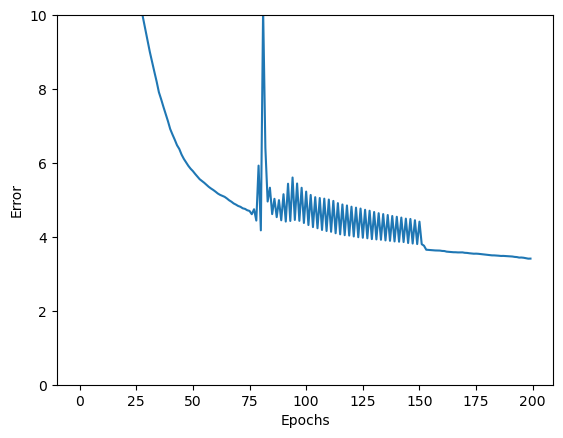

In [33]:
plot_error(classifier, 10)

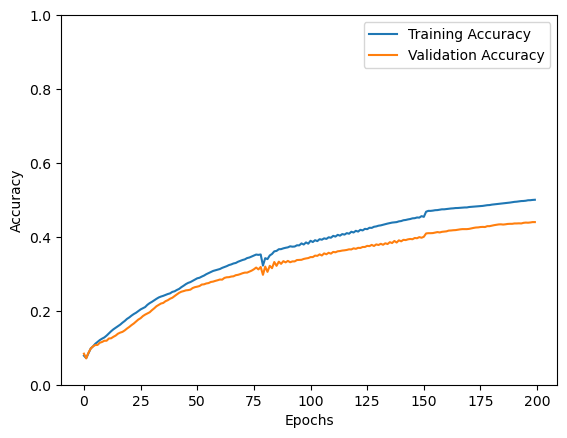

In [34]:
plot_accuracy(classifier, 1)

## 5 - Making predictions

In [35]:
pred_train = classifier.predict(train_images)
pred_test = classifier.predict(test_images)

print('train set accuracy: ', accuracy(pred_train, train_labels))
print('test set accuracy: ', accuracy(pred_test, test_labels))

train set accuracy:  0.5004166666666666
test set accuracy:  0.44


In [36]:
def check_predicted_value(images, index):
    
    pred_single = classifier.predict(images.T[index].reshape(4096, 1))
    print("The digit is " + str(pred_single[0]))

/tmp/ipykernel_30116/1864498088.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('true label: %d' % y_set.T[idx])


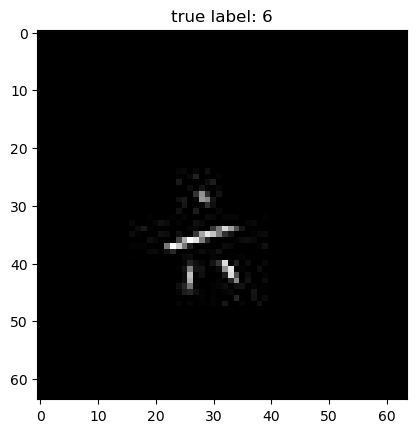

In [37]:
plot_digit(test_images, test_labels, idx=6)

In [38]:
check_predicted_value(test_images, 6)

The digit is 12


/tmp/ipykernel_30116/1864498088.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('true label: %d' % y_set.T[idx])


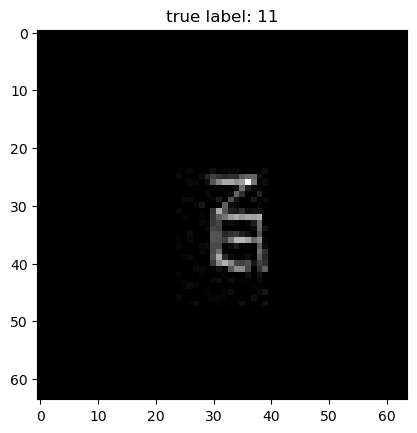

In [39]:
plot_digit(test_images, test_labels, idx=100)

In [40]:
check_predicted_value(test_images, 100)

The digit is 4


## Comparing activation functions

In [41]:
input_features = train_images.shape[0]
n_classes = len(np.unique(train_labels))
learning_rate = 0.01
hidden_layer_size = 64

# Regularization
reg_lambda_1 = 0
reg_lambda_2 = 0

reg = {'lambda_1' : reg_lambda_1, 'lambda_2':reg_lambda_2}

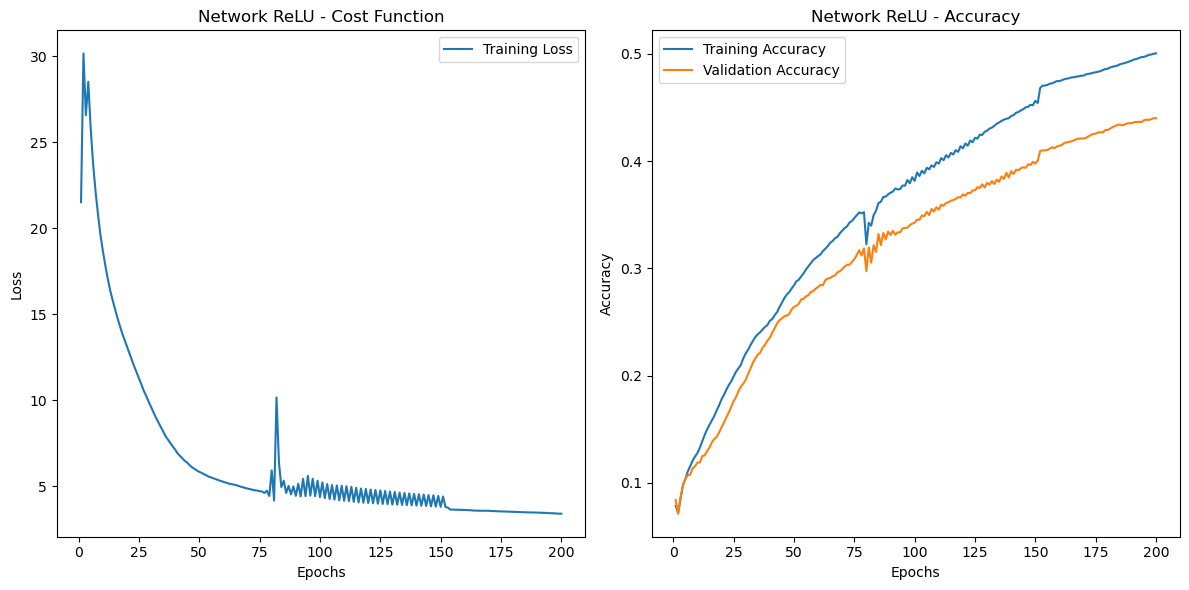

Network ReLU - Training Time: 71.84 seconds
Network ReLU - Inference Time: 0.10 seconds
************************************************************************************************************************


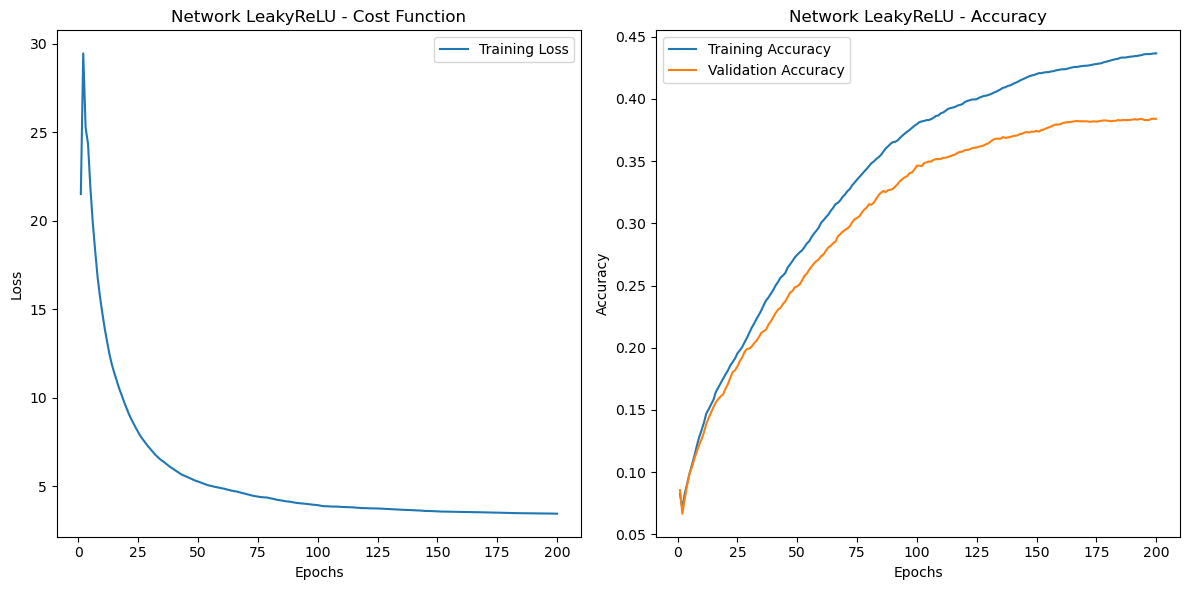

Network LeakyReLU - Training Time: 71.33 seconds
Network LeakyReLU - Inference Time: 0.11 seconds
************************************************************************************************************************


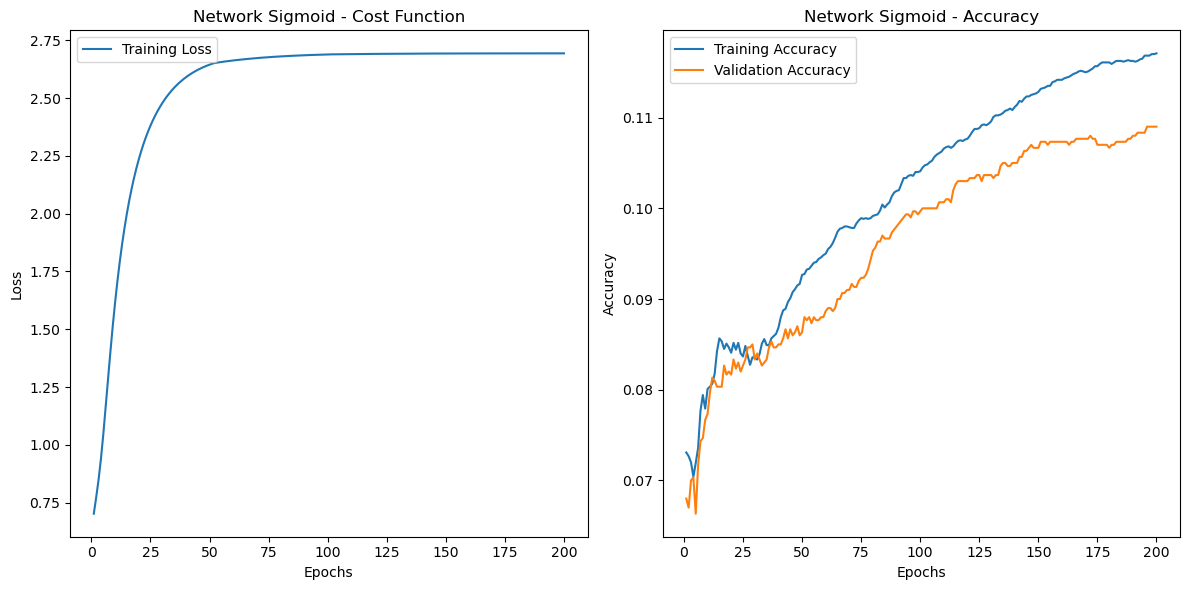

Network Sigmoid - Training Time: 84.81 seconds
Network Sigmoid - Inference Time: 0.12 seconds
************************************************************************************************************************


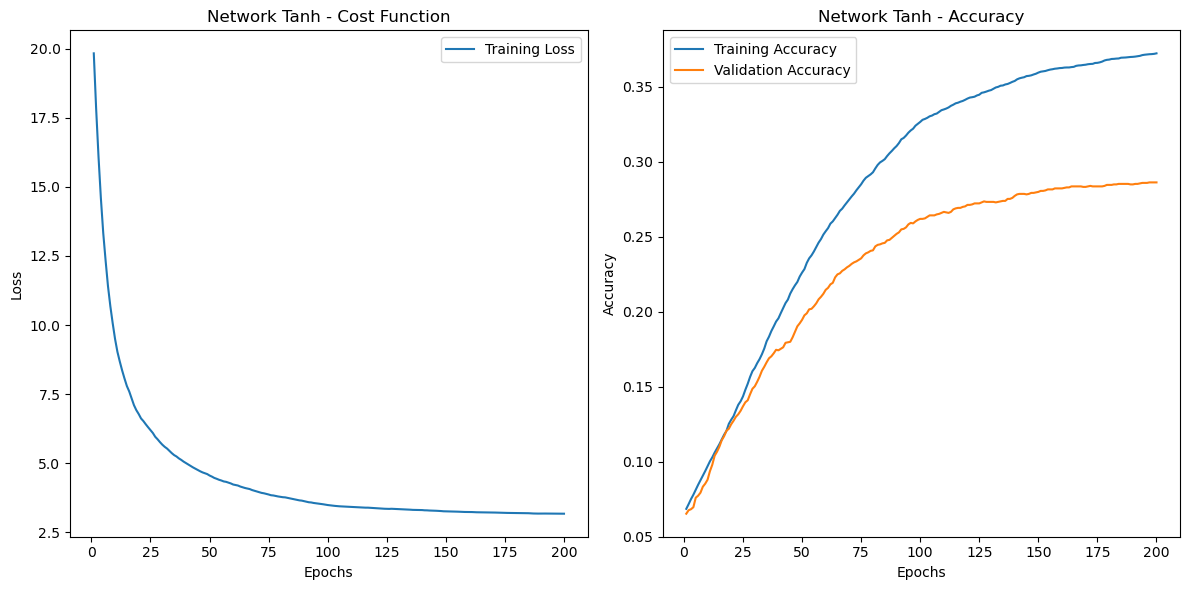

Network Tanh - Training Time: 106.99 seconds
Network Tanh - Inference Time: 0.16 seconds
************************************************************************************************************************


In [54]:
activation_functions = [ReLU(), LeakyReLU(), Sigmoid(), Tanh()]
activation_functions_names = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh']

networks = []

for activation_function in activation_functions:
    nn = NeuralNetwork(layer_sizes, learning_rate, regularization_params=reg, activation_function=activation_function, output_function=Softmax())
    networks.append(nn)

for i, nn in enumerate(networks):
    start_time = time.time()

    classifier = NNClassifier(nn, epochs=200)
    classifier.fit(train_images, train_labels)

    training_time = time.time() - start_time

    # Plot cost function
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(classifier._cost) + 1), classifier._cost, label='Training Loss')
    plt.title(f'Network {activation_functions_names[i]} - Cost Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(classifier.accuracy_train_history) + 1), classifier.accuracy_train_history, label='Training Accuracy')
    plt.plot(range(1, len(classifier.accuracy_val_history) + 1), classifier.accuracy_val_history, label='Validation Accuracy')
    plt.title(f'Network {activation_functions_names[i]} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

    print(f'Network {activation_functions_names[i]} - Training Time: {training_time - np.sum(classifier.prediction_time):.2f} seconds')
    print(f'Network {activation_functions_names[i]} - Inference Time: {np.round(np.mean(classifier.prediction_time), 2):.2f} seconds')

    print("*" * 120)
